In [27]:
import pandas as pd

auto = pd.read_csv("../../data/Auto.csv", na_values='?').dropna().set_index("name")
auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165.0,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150.0,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150.0,3433,12.0,70,1
ford torino,17.0,8,302.0,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
ford mustang gl,27.0,4,140.0,86.0,2790,15.6,82,1
vw pickup,44.0,4,97.0,52.0,2130,24.6,82,2
dodge rampage,32.0,4,135.0,84.0,2295,11.6,82,1


In [28]:
from ISLP.models import ModelSpec as MS
import statsmodels.api as sm

x = MS(["horsepower"]).fit_transform(auto)
y = auto["mpg"]

model = sm.OLS(y, x)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Thu, 17 Jul 2025   Prob (F-statistic):           7.03e-81
Time:                        22:12:02   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

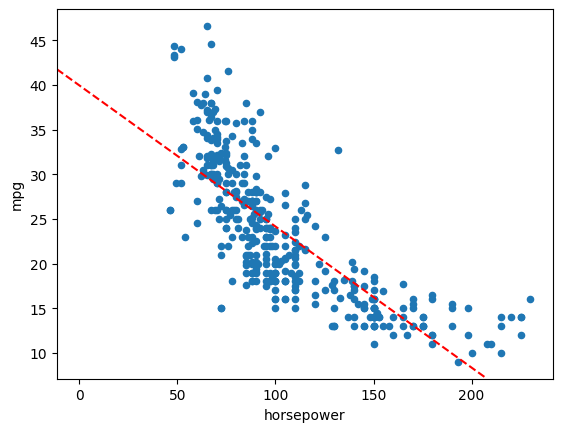

In [29]:
ax = auto.plot.scatter('horsepower', 'mpg');

ax.axline(xy1=(0, results.params.iloc[0]), slope=results.params.iloc[1], color='r', linestyle='--');

According to the regression output and the scatterplot, we can confidently conclude that there is a statistically significant relationship between horsepower and miles per gallon (mpg). The p-value for the horsepower coefficient is effectively zero (p<0.0001), indicating that the relationship is highly significant. The R-squared value of 0.606 suggests that approximately 60.6% of the variability in mpg can be explained by horsepower alone, which is substantial for a single predictor.

The coefficient for horsepower is -0.1578, meaning that for each additional unit of horsepower, mpg decreases by about 0.16 units on average. This negative relationship is clearly visible in the plot. However, the graph also reveals that the decline in mpg is steep between horsepower values of about 50 to 150, then flattens out for higher horsepower values. This pattern suggests that the true relationship may be nonlinear, and that a linear model, while informative, might not fully capture the underlying trend.

In [30]:
new_hp = pd.DataFrame({'intercept': [1], 'horsepower': [98]})

prediction = results.get_prediction(new_hp)
predicted_value = prediction.predicted_mean[0]
confidence_int = prediction.conf_int(alpha=0.05)[0]
prediction_int = prediction.conf_int(obs=True, alpha=0.05)[0]

print(f"The predicted value for a horsepower of 98 is {predicted_value:.3f},\nwith a 95% confidence interval of [{confidence_int[0]:.3f}, {confidence_int[1]:.3f}]\nand a prediction interval of  [{prediction_int[0]:.3f}, {prediction_int[1]:.3f}]")

The predicted value for a horsepower of 98 is 24.467,
with a 95% confidence interval of [23.973, 24.961]
and a prediction interval of  [14.809, 34.125]


In [31]:
import numpy as np

def non_lin(results, ax):
    x = results.fittedvalues
    y = results.resid

    X_poly = pd.DataFrame({
        'intercept': np.ones(x.shape[0]),
        'fitted values': x,
        'fitted values squared': x**2
    })

    model_poly = sm.OLS(y, X_poly)
    results_poly = model_poly.fit()
    x_sorted = np.sort(x)
    X_pred = pd.DataFrame({
        'intercept': np.ones_like(x_sorted),
        'fitted values': x_sorted,
        'fitted values squared': x_sorted**2
    })
    y_pred = results_poly.predict(X_pred)
    ax.plot(x_sorted, y_pred, color='r', linewidth=2)

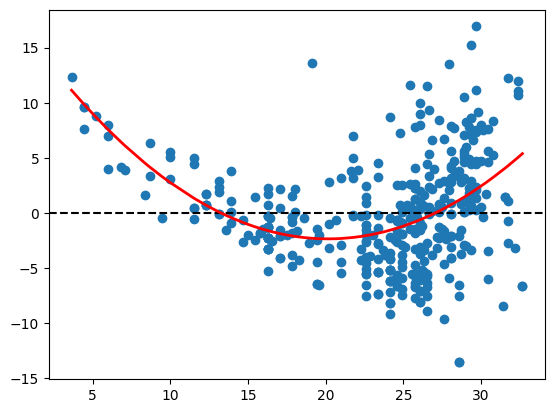

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

fitted = results.fittedvalues
residuals = results.resid

ax.scatter(fitted, residuals);
ax.axhline(0, c='k', ls='--');

non_lin(results, ax)

Based on the residual plot, there is clear evidence of non-linearity in the relationship between horsepower and mpg. The residuals display a systematic pattern rather than being randomly scattered, suggesting that the linear model may not adequately capture the underlying structure of the data.

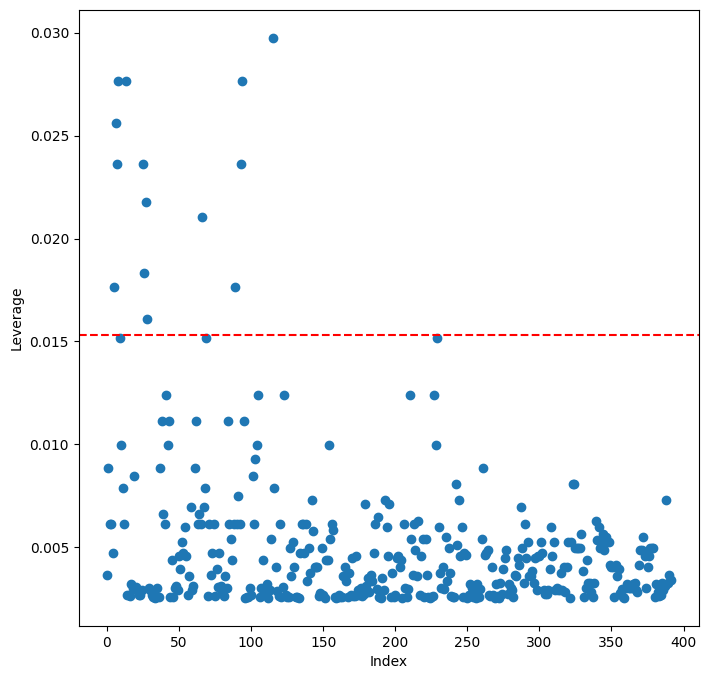

In [36]:
infl = results.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(np.arange(x.shape[0]), infl.hat_matrix_diag);
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
ax.axhline(3*x.shape[1] / x.shape[0], c='r', ls='--');


This dataset also contains several high-leverage points. Multiple observations have leverage values exceeding the threshold of $\frac{3p}{n}$, indicating they may have an outsized influence on the fitted regression model.